In [0]:
from tensorflow.keras.layers import Dense, Input, Lambda, Concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # For calculating QPSK decoding

import datetime, itertools, dill

In [0]:
# dim = 4
# N = 5

### Pilot Add

In [0]:
# def add_pilot(sym_blk):
#   pilotSym = [+1.0, 1.0]
    
#   batch_size = K.shape(sym_blk)[0]
#   enc_dim = K.shape(sym_blk)[1]

#   tx_blk = K.concatenate( [pilotSym[0]*tf.ones((batch_size,1)),sym_blk[:,:dim//2],pilotSym[1]*tf.ones((batch_size,1)),sym_blk[:,dim//2:]], axis=1 )
    
#   return tx_blk


def add_pilot(sym_blk):
  pilotSym = [+1.0, +1.0]
    
  batch_size = K.shape(sym_blk)[0]
  enc_dim = K.shape(sym_blk)[1]

  tx_blk = K.concatenate( [pilotSym[0]*tf.ones((batch_size,1)),sym_blk[:,:enc_dim//2],pilotSym[1]*tf.ones((batch_size,1)),sym_blk[:,enc_dim//2:]], axis=1 )
    
  return tx_blk


Test for ```add_pilot``` layer

In [4]:
def test_pilot_layer():
  dim = 4
  N = 5
  
  try:
    K.clear_session()
    del test_pilot_model
  except:
    pass

  in_blk = Input(shape=(dim,), name="in")
  out_blk = Lambda(add_pilot, output_shape=(dim,), name="out")(in_blk)
  test_pilot_model = Model(in_blk, out_blk, name="test_add_pilot")
  test_pilot_model.summary()

  test_pilot_model.compile('adam',loss='mse')

  x = np.random.rand(10,dim)
  y = test_pilot_model.predict(x)
  print(x)
  print(y)

test_pilot_layer()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 4)                 0         
_________________________________________________________________
out (Lambda)                 (None, None)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[[0.98380186 0.50317473 0.31324788 0.74991473]
 [0.02169882 0.89193026 0.74696222 0.56608409]
 [0.35742228 0.58517112 0.58277263 0.11276546]
 [0.67478985 0.79118923 0.03139475 0.10610964]
 [0.17935459 0.83701818 0.02492929 0.82804138]
 [0.06181282 0.85074114 0.55639604 0.69686869]
 [0.30935265 0.22877928 0.07296392 0.74602613]
 [0.21158031 0.92246603 0.5136376  0.58786741]
 [0.50364612 0.70621856 0.03472033 0.3332177 ]
 

## RBF Channel

In [0]:
# def rbf_channel( inputs ):
  
#   symbol_tensor, h1_tensor, h2_tensor = inputs

#   batch = K.shape( symbol_tensor )[0]
  
  
#   p2 = K.concatenate( [-symbol_tensor[:,1+dim//2:],symbol_tensor[:,:dim//2+1]] )
  
#   t1 = h1_tensor*symbol_tensor + h2_tensor*p2
# #   t1 = h[:,0,None]*symbol_tensor + h[:,1,None]*symbol_tensor
  
# #   epsilon = K.random_normal( shape = (batch,dim+2) )
  
#   return t1




def rbf_channel( inputs ):
  
  symbol_tensor, h1_tensor, h2_tensor, n0_tensor = inputs

  batch_size = K.shape(symbol_tensor)[0]
  enc_dim = K.shape(symbol_tensor)[1]
  
  p2 = K.concatenate( [-symbol_tensor[:,enc_dim//2:],symbol_tensor[:,:enc_dim//2]] )
  
  t1 = h1_tensor*symbol_tensor + h2_tensor*p2
#   t1 = h[:,0,None]*symbol_tensor + h[:,1,None]*symbol_tensor
  
  epsilon = K.random_normal( shape=K.shape(symbol_tensor), stddev=K.sqrt(n0_tensor) )
  
  return t1 + epsilon

Test Channel

In [6]:
def test_channel_layer():
  dim = 4
  N = 5
  try:
    K.clear_session()
    del m
  except:
    pass

  in_blk = Input(shape=(dim+2,), name="in")

  in_h1 = Input(shape=(1,), name="h1")
  in_h2 = Input(shape=(1,), name="h2")
  in_n0 = Input(shape=(1,), name="n0")
  outputs = Lambda(rbf_channel, output_shape=(dim,), name="out")((in_blk,in_h1,in_h2,in_n0))
  m = Model([in_blk,in_h1,in_h2,in_n0], outputs, name="channel")

  m.summary()


  inBlk = np.random.rand(N,dim+2)
  h1 = np.sqrt(1/2) * np.random.randn(N)
  h2 = np.sqrt(1/2) * np.random.randn(N)
  n0 = 1e-12 * np.ones(N)

  # h1 = np.ones(N)
  # h2 = np.zeros(N)

  # h1 = np.zeros(N)
  # h2 = np.ones(N)

  p1 = inBlk[:,:]
  p2 = np.hstack((-inBlk[:,inBlk.shape[1]//2:],inBlk[:,:inBlk.shape[1]//2]))
  outBlk = h1[:,None]*p1 + h2[:,None]*p2

  # print("inBlk\n", inBlk)
  print("h1,h2:\n", (h1,h2))
  # # print("h:\n", (h))
  # print("p1\n", p1)
  # print("p2\n", p2)
  print("outBlk\n", outBlk)

  chOut = m.predict([inBlk, h1, h2,n0])
  print("ChOut\n", chOut)
  
  print( outBlk-chOut < 1e-5)

test_channel_layer()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 6)            0                                            
__________________________________________________________________________________________________
h1 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
h2 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
n0 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
out (Lambd

Pilot Integration

In [7]:
def test_pilot_integration():
  dim = 4
  N = 5

  try:
    K.clear_session()
    del m
  except:
    pass

  in_blk = Input(shape=(dim,), name="in")

  in_h1 = Input(shape=(1,), name="h1")
  in_h2 = Input(shape=(1,), name="h2")
  in_n0 = Input(shape=(1,), name="n0")

  tx_blk = Lambda(add_pilot, output_shape=(dim+2,), name="tx_blk")(in_blk) 
  ch_out = Lambda(rbf_channel, output_shape=(dim+2,), name="ch_out")((tx_blk,in_h1,in_h2,in_n0))
  m = Model([in_blk,in_h1,in_h2,in_n0], ch_out, name="test_pilot_channel")

  m.summary()


  inBlk = np.random.rand(N,dim)

  h1 = np.sqrt(1/2) * np.random.randn(N)
  h2 = np.sqrt(1/2) * np.random.randn(N)
  n0 = 1e-12 * np.ones(N)


  # h1 = np.ones(N)
  # h2 = np.zeros(N)

  # h1 = np.zeros(N)
  # h2 = np.ones(N)


  # h = np.sqrt(1/2) * np.random.randn(N,2)
  # print(h.shape)

  p1 = inBlk[:,:]
  p2 = np.hstack((-inBlk[:,inBlk.shape[1]//2:],inBlk[:,:inBlk.shape[1]//2]))
  # outBlk = h[:,0,None]*p1 + h[:,1,None]*p2
  outBlk = h1[:,None]*p1 + h2[:,None]*p2

  # print("inBlk\n", inBlk)
  print("h1,h2:\n", (h1,h2))
  # # print("h:\n", (h))
  print("p1\n", p1)
  print("p2\n", p2)
  print("outBlk\n", outBlk)

  chOut = m.predict([inBlk, h1, h2, n0])
  # chOut = np.delete(chOut[0],[0,dim//2+1], axis=1)
  print("Ch Out\n", chOut)
  
test_pilot_integration()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 4)            0                                            
__________________________________________________________________________________________________
tx_blk (Lambda)                 (None, None)         0           in[0][0]                         
__________________________________________________________________________________________________
h1 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
h2 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
n0 (InputL

## Equalizer

In [0]:
# def equalizer(rx_blk):
  
#   pilotSym = [+1.0, +1.0]

#   rx_pilot0 = rx_blk[:,0]
#   rx_pilot1 = rx_blk[:,1+dim//2]
  
#   h1_hat = (pilotSym[1]*rx_pilot1+pilotSym[0]*rx_pilot0)/(pilotSym[0]**2+pilotSym[1]**2)
#   h2_hat = (pilotSym[0]*rx_pilot1-pilotSym[1]*rx_pilot0)/(pilotSym[0]**2+pilotSym[1]**2)    
    
#   z1_hat = rx_blk[:,:dim//2+1]
#   z2_hat = rx_blk[:,dim//2+1:]
    
    
#   zR = (h1_hat[:,None]*z1_hat+h2_hat[:,None]*z2_hat) / (h1_hat[:,None]**2+h2_hat[:,None]**2)
#   zI = (h1_hat[:,None]*z2_hat-h2_hat[:,None]*z1_hat) / (h1_hat[:,None]**2+h2_hat[:,None]**2)
    
#   out_blk = K.concatenate((zR[:,1:],zI[:,1:]))
# #   out_blk = K.concatenate((zR,zI))
    
#   return out_blk



def equalizer(rx_blk):
  
  batch_size = K.shape(rx_blk)[0]
  enc_dim = K.shape(rx_blk)[1]
  
  
  pilotSym = [+1.0, +1.0]

  rx_pilot0 = rx_blk[:,0]
  rx_pilot1 = rx_blk[:,enc_dim//2]
  
  h1_hat = (pilotSym[1]*rx_pilot1+pilotSym[0]*rx_pilot0)/(pilotSym[0]**2+pilotSym[1]**2)
  h2_hat = (pilotSym[0]*rx_pilot1-pilotSym[1]*rx_pilot0)/(pilotSym[0]**2+pilotSym[1]**2)    
    
  z1_hat = rx_blk[:,:enc_dim//2]
  z2_hat = rx_blk[:,enc_dim//2:]
    
    
  zR = (h1_hat[:,None]*z1_hat+h2_hat[:,None]*z2_hat) / (h1_hat[:,None]**2+h2_hat[:,None]**2)
  zI = (h1_hat[:,None]*z2_hat-h2_hat[:,None]*z1_hat) / (h1_hat[:,None]**2+h2_hat[:,None]**2)
    
  out_blk = K.concatenate((zR[:,1:],zI[:,1:]))
#   out_blk = K.concatenate((zR,zI))
    
  return out_blk


In [9]:
def test_full_model():
  dim = 4
  N = 5

  try:
    K.clear_session()
    del m
  except:
    pass

  in_blk = Input(shape=(dim,), name="in")

  in_h1 = Input(shape=(1,), name="h1")
  in_h2 = Input(shape=(1,), name="h2")
  in_n0 = Input(shape=(1,), name="n0")


  tx_blk = Lambda(add_pilot, output_shape=(dim+2,), name="tx_blk")(in_blk) 
  ch_out = Lambda(rbf_channel, output_shape=(dim+2,), name="ch_out")((tx_blk,in_h1,in_h2,in_n0))
  rx_blk = Lambda(equalizer, output_shape=(dim+2,), name="rx_blk")(ch_out)

  m = Model([in_blk,in_h1,in_h2,in_n0], rx_blk, name="test_model")

  # m.summary()


  inBlk = np.random.rand(N,dim)

  h1 = np.sqrt(1/2) * np.random.randn(N)
  h2 = np.sqrt(1/2) * np.random.randn(N)
  n0 = 1e-12 * np.ones(N)

  # h1 = np.ones(N)
  # h2 = np.zeros(N)
  # h1 = np.zeros(N)
  # h2 = -np.ones(N)


  # h = np.sqrt(1/2) * np.random.randn(N,2)
  # print(h.shape)

  p1 = inBlk[:,:]
  p2 = np.hstack((-inBlk[:,dim//2:],inBlk[:,:dim//2]))
  # outBlk = h[:,0,None]*p1 + h[:,1,None]*p2
  outBlk = h1[:,None]*p1 + h2[:,None]*p2

  print("inBlk\n", inBlk)
  print("h1,h2:\n", (h1,h2))
  # print("p1\n", p1)
  # print("p2\n", p2)
  # print("outBlk\n", outBlk)

  eqBlk = m.predict([inBlk, h1, h2, n0])
  print("OUT>>\n", eqBlk)

  print( inBlk-eqBlk < 1e-5 )
  
test_full_model()

inBlk
 [[0.6546834  0.02271731 0.1319668  0.7709766 ]
 [0.84280018 0.7653356  0.65925493 0.15561915]
 [0.89263706 0.82569732 0.82164695 0.77409137]
 [0.32928738 0.21169979 0.17188034 0.07117206]
 [0.67201581 0.24592269 0.87050381 0.10354727]]
h1,h2:
 (array([-0.8874821 ,  1.02133235,  0.12608669, -0.96486442, -0.1834301 ]), array([ 1.06682086,  1.13726804,  0.98384061, -0.46521764,  0.1267637 ]))
OUT>>
 [[0.6546837  0.02271589 0.1319669  0.77097535]
 [0.84280074 0.7653366  0.65925545 0.15561871]
 [0.8926353  0.82569444 0.82164913 0.77409226]
 [0.329287   0.21169837 0.17187984 0.07117234]
 [0.6720094  0.24593    0.8704973  0.10354299]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


# Test QAM

In [0]:
import numpy as np
from itertools import cycle, product
import dill

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [0]:
blkSize     = 4
chDim       = 2

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

SNR_range_dB = np.arange( 0.0, 41.0, 1.0 )

results = {}

In [12]:
qam_map = np.array(list(map(list, product([-1.0, +1.0], repeat=blkSize))))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

noisePower = qam_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

QAM Avg. Tx Power: 4.0


In [13]:
try:
  K.clear_session()
  del m
except:
  pass

in_blk = Input(shape=(encDim,), name="in")

in_h1 = Input(shape=(1,), name="h1")
in_h2 = Input(shape=(1,), name="h2")
in_n0 = Input(shape=(1,), name="n0")


tx_blk = Lambda(add_pilot, output_shape=(encDim+2,), name="tx_blk")(in_blk) 
ch_out = Lambda(rbf_channel, output_shape=(encDim+2,), name="ch_out")((tx_blk,in_h1,in_h2,in_n0))
rx_blk = Lambda(equalizer, output_shape=(encDim+2,), name="rx_blk")(ch_out)

m = Model([in_blk,in_h1,in_h2,in_n0], rx_blk, name="complete_model")

m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 4)            0                                            
__________________________________________________________________________________________________
tx_blk (Lambda)                 (None, None)         0           in[0][0]                         
__________________________________________________________________________________________________
h1 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
h2 (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
n0 (InputL

In [14]:
err = []
for (idx,n0) in enumerate(n0_per_comp):
  print( "{}/{} {}".format(idx,n0_per_comp.shape[0],n0))
  thisErr = 0
  thisCount = 0
  while thisErr < 500:
    txSym = np.random.randint(inVecDim, size=1000)
    symBlk = qam_map[txSym]
    
    h1 = np.sqrt(1/2) * np.random.randn(txSym.shape[0])
    h2 = np.sqrt(1/2) * np.random.randn(txSym.shape[0])
    _n0 = n0 * np.ones(txSym.shape[0])
    
#     txTest = add_pilot(symBlk)
#     rxTest, _, _ = rbf_channel(txTest, n0)
#     rxEqualized, _, _ = equalizer(rxTest)
    
    rxEqualized = m.predict([symBlk, h1, h2, _n0])
    rxDecode = cdist(rxEqualized, qam_map)
    rxSym = np.argmin(rxDecode,axis=1)
    thisErr += np.sum(rxSym!=txSym)
    thisCount += 1000
  err.append(thisErr/thisCount)
results["QAM"] = np.array(err)

0/41 1.0
1/41 0.7943282347242815
2/41 0.6309573444801932
3/41 0.5011872336272722
4/41 0.3981071705534972
5/41 0.31622776601683794
6/41 0.251188643150958
7/41 0.19952623149688797
8/41 0.15848931924611134
9/41 0.12589254117941673
10/41 0.1
11/41 0.07943282347242814
12/41 0.06309573444801933
13/41 0.05011872336272722
14/41 0.039810717055349734
15/41 0.03162277660168379
16/41 0.025118864315095794
17/41 0.0199526231496888
18/41 0.015848931924611134
19/41 0.012589254117941675
20/41 0.01
21/41 0.007943282347242814
22/41 0.00630957344480193
23/41 0.005011872336272725
24/41 0.003981071705534973
25/41 0.0031622776601683794
26/41 0.0025118864315095794
27/41 0.001995262314968879
28/41 0.001584893192461114
29/41 0.0012589254117941675
30/41 0.001
31/41 0.0007943282347242813
32/41 0.000630957344480193
33/41 0.0005011872336272725
34/41 0.00039810717055349735
35/41 0.00031622776601683794
36/41 0.00025118864315095795
37/41 0.00019952623149688788
38/41 0.00015848931924611142
39/41 0.00012589254117941674


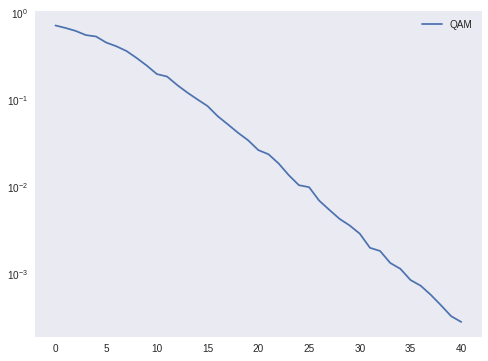

In [16]:
fig = plt.figure(figsize=(8,6))
for (l,v) in results.items():
    plt.semilogy(SNR_range_dB, v, label=l)
plt.legend()
plt.grid()